In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
sys.path.append("..")
sys.path.append("../..")
sys.path.append("/da_dev/qgs/")

import warnings
from typing import Callable, Tuple

import matplotlib.pyplot as plt
import numpy as np
import tqdm
from numba.core.errors import NumbaPerformanceWarning

warnings.simplefilter('ignore', category=NumbaPerformanceWarning)
# m = n * (nobs + 1)
from common.numerical_model import NumericalModel
from common.observation_operator import IdentityObservationOperator
from dynamical_systems.quasigeostrophic_numerical_model import create_QG_model, create_QG_model_grid

plt.style.use("seaborn") #type: ignore
plt.set_cmap('magma')
from qgs.QG import QGwrapper #type: ignore

# Let us set a rng for reproducibility
rng = np.random.default_rng(seed=93)

qg_model = QGwrapper(wavenumbers=(3, 2), tsteps=0.05, write_steps=1, dt=0.01)
qg_model.configure(tangent_linear=True)
qg_model.burn_model(burn=20_000)

Number of (spectral) parameters = 2y*(2x+1) = 28
Number of grid points = 4x+2, 4y+2 = (14, 10) = 140
Number of saved points: 6


<Figure size 432x288 with 0 Axes>

In [3]:
# plt.subplot(1, 2, 1)
# plt.imshow(np.cov(traj))
# plt.subplot(1, 2, 2)
# plt.imshow(np.linalg.inv(np.cov(traj)))
# np.linalg.slogdet(np.cov(traj))


In [4]:
# import os
# if not os.path.exists(f'quasi_geostrophic_Binv/Binv_{qg_model.x}_{qg_model.y}.npy'):
#     time, traj = qg_model.forward(qg_model.initial_conditions, tsteps=10_000, write_steps=10)
#     print(traj.shape)
#     plt.subplot(1, 2, 1)
#     plt.imshow(np.cov(traj))
#     plt.subplot(1, 2, 2)
#     plt.imshow(np.linalg.inv(np.cov(traj)))
#     np.linalg.slogdet(np.cov(traj))
#     np.save(f"quasi_geostrophic_Binv/Binv_{qg_model.x}_{qg_model.y}.npy", np.linalg.inv(np.cov(traj)))

In [5]:
# ## Run model for 1 day
# qg_model.change_settings(tsteps=0.5 * qg_model.tstep_1day, write_steps=1, dt=None)
# GN, (time, _, _) = qg_model.GaussNewtonMatrix(qg_model.initial_conditions)
# slogdet = np.linalg.slogdet(GN)
# print(slogdet, np.linalg.cond(GN))
# plt.subplot(1, 2, 1)
# plt.title(np.linalg.slogdet(GN))
# plt.imshow(GN)
# plt.subplot(1, 2, 2)
# plt.title(np.linalg.cond(GN))
# plt.plot(np.linalg.eigvalsh(GN))
# plt.yscale("log")
# plt.tight_layout()

# t, traj, jacobian_ = qg_model.forward_jacobian(x=qg_model.initial_conditions)
# jacobian = jacobian_[:, :, -1]

In [6]:
from common.observation_operator import RandomObservationOperator


tsteps = qg_model.tstep_1day * 1.0
qg_model.change_settings(tsteps=tsteps, write_steps=1, dt=None)
print(f"{(tsteps / qg_model.tstep_1day) * 24:.2f} hours")
obs_operator = RandomObservationOperator(2 * qg_model.grid_x * qg_model.grid_y, 2 * qg_model.grid_x * qg_model.grid_y, type='square', p=0.5, p_offdiag=0.01)
obs_operator = IdentityObservationOperator(2 * qg_model.grid_x * qg_model.grid_y, 2 * qg_model.grid_x * qg_model.grid_y)


truth = np.moveaxis(np.array(qg_model.forward_grid(qg_model.initial_conditions)[2])[:, -1, :, :], -1, -2).flatten()

obs = truth + np.random.normal(size=truth.shape)
qg_model.obs = obs

Binv = np.load(f"quasi_geostrophic_Binv/Binv_{qg_model.x}_{qg_model.y}.npy")
L = np.linalg.cholesky(np.linalg.inv(Binv))

background = np.zeros(qg_model.spectral_dim), Binv, L
# background = None
# model, sp_fun, gn_fun = create_QG_model(qg_model, obs_operator=obs_operator, background=background, test=False, gnparams=(50, 10, 0.1))
model, _, _ = create_QG_model_grid(qg_model, obs_operator=obs_operator, background=background, test=False, gnparams=(10, 10, 0.1))
# model, _, _ = create_QG_model_grid(qg_model, obs_operator=obs_operator, background=background, test=True, gnparams=(50, 10, 0.1))

x0 = np.zeros(qg_model.spectral_dim)


tsteps is overwritten
Previous tsteps: 20000
New tsteps: 8.91648 (1.000 days)
writesteps is overwritten
Previous write_steps: 0
New write_steps: 1
24.00 hours


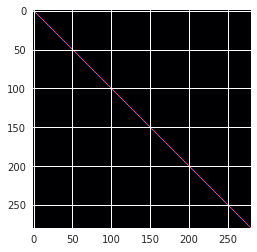

In [7]:
plt.imshow(obs_operator.H)

In [8]:
import scipy.optimize
res = model.GNmethod(qg_model.initial_conditions, n_outer=10, n_inner=500, verbose=True)
# sp_opt = scipy.optimize.minimize(model.cost_function, x0)
# sp_x, sp_fun = sp_opt.x, sp_opt.fun
print(f"scipy: {sp_fun}")
print(f"GN: {res[1]}")
plt.plot(res[0], label='GN')
plt.plot(sp_x, label='scipy')
plt.legend()
GN_no_prec = res[0]

niter,     f(x),  CG iter, log-det,   cond
    0, 134.0000,       38, 222.69, 1.9999e+02
    1, 132.0443,       37, 223.08, 2.2661e+02
    2, 133.0125,       35, 222.63, 2.1379e+02
    3, 132.7591,       36, 222.61, 2.2546e+02
    4, 134.6401,       37, 222.47, 2.0582e+02
    5, 134.1401,       37, 222.41, 2.1482e+02
    6, 136.6404,       37, 222.01, 1.9709e+02
    7, 135.1765,       37, 222.09, 2.1414e+02
    8, 136.8174,       36, 222.34, 1.6209e+02
    9, 133.2899,       36, 221.71, 2.3202e+02


NameError: name 'sp_opt' is not defined

In [ ]:
print(f"scipy: {sp_fun}")


scipy: 1234.9633403145663


In [9]:
import scipy.optimize
res = model.GNmethod(qg_model.initial_conditions, n_outer=10, n_inner=500, verbose=True, prec='bck')
sp_opt = scipy.optimize.minimize(model.cost_function, x0)
sp_x, sp_fun = sp_opt.x, sp_opt.fun
print(f"scipy: {sp_fun}")
print(f"GN: {res[1]}")
plt.plot(res[0], label='GN')
plt.plot(sp_x, label='scipy')
plt.legend()
GN_no_prec = res[0]

niter,     f(x),  CG iter, log-det,   cond


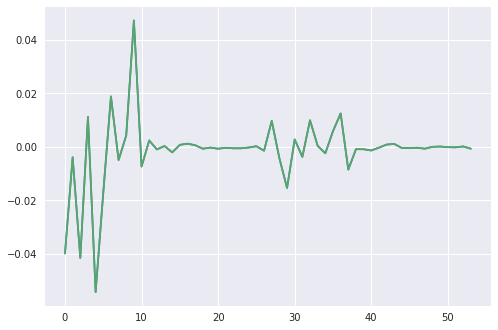

In [ ]:
plt.plot(res[0], label='GN')
plt.plot(qg_model.initial_conditions)

In [ ]:
def get_GN(x0):
    traj_, jac_grid = qg_model.forward_jacobian_grid(qg_model.initial_conditions, return_traj=True)
    G = np.asarray((jac_grid))[..., -1].reshape(-1, 54)
    return traj_[:, -1], G.T @ G


((18, 14, 54, 893), (54, 893))

In [ ]:
traj = traj_[:, -1]
jac_up = jac_grid[0][..., -1]
jac_low = jac_grid[1][..., -1]

In [ ]:
traj.shape, jac_low.shape, jac_up.shape

((54,), (18, 14, 54), (18, 14, 54))

In [ ]:
traj.shape

(54,)